# Accessing Visual Behavior Neuropixels Raw Data

## Tutorial overview

This Jupyter notebook covers a few of the many methods for accessing raw data from the Allen Institute Visual Behavior Neuropixels dataset. 

We focus here on accessing the video data files, as they are most likely to be of interest to users,
but the same methods apply to the raw ecephys data as well.

Raw data is stored on **Amazon Web Services (AWS)** **Simple Storage Service (S3)**, at `s3://allen-brain-observatory/visual-behavior-neuropixels/raw-data/`.

Unlike the processed NWB files, the raw data is not downloaded automatically by the AllenSDK cache. Instead, it must be accessed directly from S3 using one of the methods described in this tutorial:

1. **Web browser access** - Browse the file-tree, stream videos directly in your browser, and
   download files one at a time
2. **AWS CLI** - Bulk download files using the AWS command-line tool
3. **boto3 Python library** - Programmatically access and download files using Python, including
   streaming 

This tutorial doesn't assume you have any familiarity with the Visual Behavior Neuropixels dataset.

For a full list of available tutorials, see the [SDK documentation](https://allensdk.readthedocs.io/en/latest/visual_behavior_neuropixels.html).

In [1]:
# required imports for the code snippets in this notebook
from typing import Literal, Union

import boto3
import cv2
import matplotlib.pyplot as plt
from botocore import UNSIGNED
from botocore.config import Config

---
# Video data

## Overview of video data folder structure

Behavior videos are organized on S3 by session ID:

```
s3://allen-brain-observatory/visual-behavior-neuropixels/raw-data/<session_id>/behavior_videos/
```

Each session directory contains 3 video files -- each capturing the subject's behavior from a
different viewpoint -- plus camera metadata and frame timestamps associated with each video. 

- `eye.mp4`                 # close-up view of the right eye and surrounding area
- `eye_metadata.mp4`
- `eye_timestamps.npy`
- `face.mp4`                # front-on view of the subject, mainly showing the face
- `face_metadata.mp4`
- `face_timestamps.npy`
- `side.mp4`                # side-on view of the subject's entire body (left side)
- `side_metadata.mp4`
- `side_timestamps.npy`

---
## Method 1: Web browser access via Quilt

The easiest way to browse and access video files is through the Quilt web interface. This is a website that allows you to explore the data structure, stream videos directly in your browser, and download files without any special tools or credentials.

**Web interface URL:**
[`https://open.quiltdata.com/b/allen-brain-observatory/tree/visual-behavior-neuropixels/raw-data/`](https://open.quiltdata.com/b/allen-brain-observatory/tree/visual-behavior-neuropixels/raw-data/)


### Example: Accessing videos for a specific session

Let's say you want to access videos for session `1043752325`. You would navigate to:

[`https://open.quiltdata.com/b/allen-brain-observatory/tree/visual-behavior-neuropixels/raw-data/1043752325/behavior_videos/`](https://open.quiltdata.com/b/allen-brain-observatory/tree/visual-behavior-neuropixels/raw-data/1043752325/behavior_videos/)

From this interface, you can:
- **Stream** videos directly in your browser by clicking on their name
- **Download** individual files by hovering over the file's row and clicking the download arrow icon:

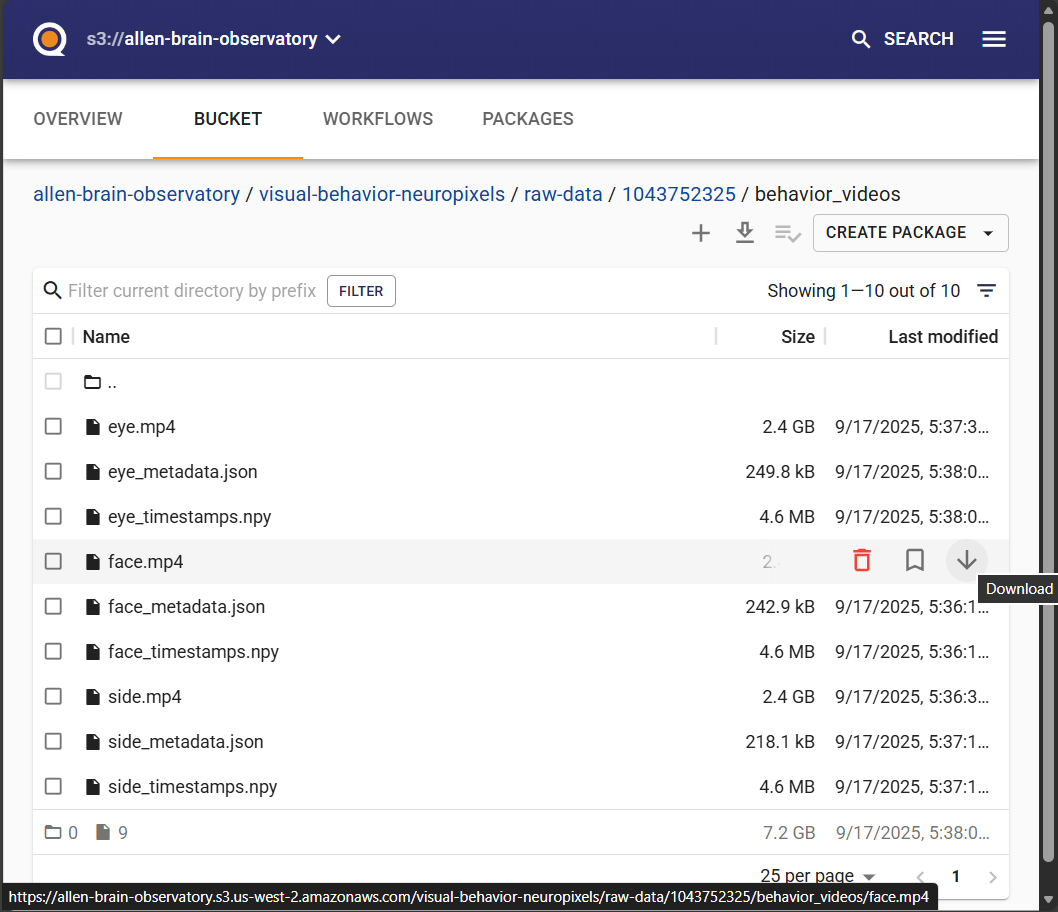

---
## Method 2: Using the AWS CLI

The AWS Command Line Interface (CLI) is a powerful tool for interacting with many AWS services: we can use it to interact with the video data on S3 and download files. The AWS CLI is particularly efficient for downloading many files, or large files.

### Installing the AWS CLI

Follow the [official installation instructions](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html) for your operating system.

### Downloading video files

Since this is a public bucket, you don't need AWS credentials: you can use the `--no-sign-request` flag to access the data "anonymously".

**List all video files for a session with `ls`:**
```bash
aws s3 ls s3://allen-brain-observatory/visual-behavior-neuropixels/raw-data/1043752325/behavior_videos/ --no-sign-request
```

**Download files with `cp`:**

The `aws s3 cp` command allows you to download one or more files to a local directory. See the
documentation for more details: [AWS S3 cp
command](https://docs.aws.amazon.com/cli/latest/reference/s3/cp.html).

- single video:
    ```bash
    aws s3 cp s3://allen-brain-observatory/visual-behavior-neuropixels/raw-data/1043752325/behavior_videos/side.mp4 ./raw-data/1043752325/behavior_videos/ --no-sign-request
    ```

- all videos:
    ```bash
    aws s3 cp s3://allen-brain-observatory/visual-behavior-neuropixels/raw-data/ ./raw-data/ --recursive --exclude "*" --include "*.mp4" --include "*_metadata.json" --include "eye_timestamps.npy" --include "face_timestamps.npy" --include "side_timestamps.npy" --no-sign-request --dryrun
    ```
    Note that `--dryrun` allows you to preview which files would be downloaded without actually downloading them - remove this flag to perform the actual download.

---
## Method 3: Using boto3 in Python

For programmatic access within Python, you can use the `boto3` library, which is the AWS SDK for Python.

### Set up boto3 client

Since this is a public bucket, we configure boto3 to use unsigned requests (no AWS credentials required):

In [ ]:
# Create an S3 client configured for unsigned (anonymous) requests
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# Define the bucket name and base path
BUCKET_NAME = 'allen-brain-observatory'
BASE_PATH = 'visual-behavior-neuropixels/raw-data'

### List available video files for a session

Let's define a function to list all video files for a given session:

In [18]:
def list_video_paths(session_id: int | str) -> list[str]:
    """
    List paths of video files available for a given session.
    
    Parameters
    ----------
    session_id : int or str
        The session ID to query
        
    Returns
    -------
    list of str
        List of video file names
    """
    prefix = f"{BASE_PATH}/{session_id}/behavior_videos/"
    
    response = s3_client.list_objects_v2(
        Bucket=BUCKET_NAME,
        Prefix=prefix
    )
    
    if 'Contents' not in response:
        print(f"No video files found for session {session_id}")
        return []
    
    paths = [obj['Key'] for obj in response['Contents'] 
                   if not obj['Key'].endswith('/')]  # Exclude directory markers
    
    return paths

    
# Example: List videos for a specific session
session_id = 1043752325
paths = list_video_paths(session_id)

print(f"Found {len(paths)} video-related file(s) for session {session_id}.\ns3 keys:")
for file_path in paths:
    print(f"  - {file_path}")

Found 9 video-related file(s) for session 1043752325.
s3 keys:
  - visual-behavior-neuropixels/raw-data/1043752325/behavior_videos/eye.mp4
  - visual-behavior-neuropixels/raw-data/1043752325/behavior_videos/eye_metadata.json
  - visual-behavior-neuropixels/raw-data/1043752325/behavior_videos/eye_timestamps.npy
  - visual-behavior-neuropixels/raw-data/1043752325/behavior_videos/face.mp4
  - visual-behavior-neuropixels/raw-data/1043752325/behavior_videos/face_metadata.json
  - visual-behavior-neuropixels/raw-data/1043752325/behavior_videos/face_timestamps.npy
  - visual-behavior-neuropixels/raw-data/1043752325/behavior_videos/side.mp4
  - visual-behavior-neuropixels/raw-data/1043752325/behavior_videos/side_metadata.json
  - visual-behavior-neuropixels/raw-data/1043752325/behavior_videos/side_timestamps.npy


To download individual files use:
```python
s3_client.download_file(BUCKET_NAME, s3_key, str(destination_path))
```

---
## Working with videos in Python

We can stream videos directly from S3 without downloading them first, using OpenCV and boto3 together.

### Stream video directly from S3 using a presigned URL

OpenCV can read videos directly from URLs. We'll generate a presigned URL for the S3 object and pass it to OpenCV:

In [ ]:
def get_video_obj(session_id: Union[int, str], camera: Literal['eye', 'face', 'side']) -> cv2.VideoCapture:
    """
    Get an OpenCV VideoCapture object for a specific session video.
    
    The video is streamed directly from S3 using a presigned URL - no download required.
    
    Parameters
    ----------
    session_id : int or str
        The session ID
    camera : Literal['eye', 'face', 'side']
        Which camera's video to access
        
    Returns
    -------
    cv2.VideoCapture
        OpenCV VideoCapture object for reading frames from the video
        
    Examples
    --------
    >>> vid_obj = get_video_obj(1043752325, 'face')
    >>> _, frame = vid_obj.read()
    >>> vid_obj.release()
    """
    if camera not in ('eye', 'face', 'side'):
        raise ValueError(f"Invalid camera name: {camera!r}. Must be 'eye', 'face', or 'side'.")
    
    # Construct the S3 key
    s3_key = f"{BASE_PATH}/{session_id}/behavior_videos/{camera}.mp4"
    
    # Generate a streaming URL that can be opened by OpenCV (valid for 24 hours)
    url = s3_client.generate_presigned_url(
        'get_object',
        Params={'Bucket': BUCKET_NAME, 'Key': s3_key},
        ExpiresIn=3600 * 24,
    )
    
    # Open the video directly from the URL
    cap = cv2.VideoCapture(url)
    
    if not cap.isOpened():
        raise ValueError(f"Failed to open video file {s3_key}")
    
    return cap

Let's get a video and display the *second* frame (the first is an artifical frame containing metadata, added by the video capture software):

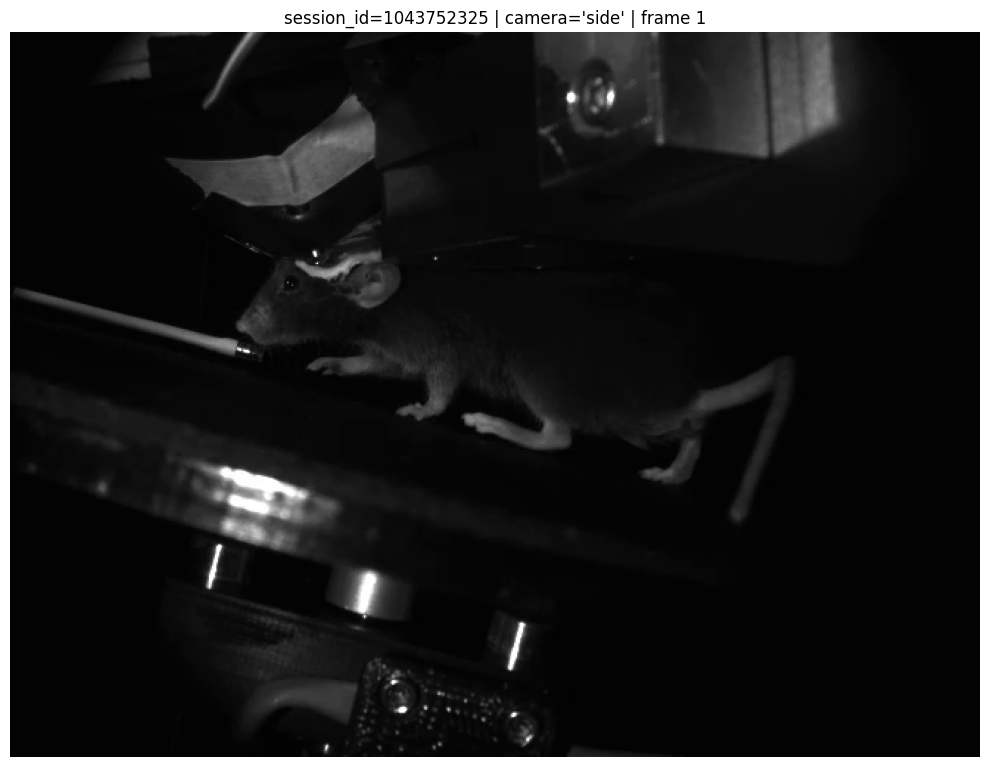

Frame shape: (492, 658, 3)
Frame dtype: uint8


In [ ]:
# Get the cv2 video object for a specific video file:
session_id = 1043752325
camera = 'side'
vid_obj = get_video_obj(session_id, camera)

# Read and discard the first frame (metadata frame)
_ = vid_obj.read()

# Read the next frame (first actual video frame)
is_frame, frame_data = vid_obj.read()

# NOTE: while it is possible (and convenient) to jump to a specific frame and read it with the
# following code it is not recommended due to known issues with video decoding with OpenCV. 
# See https://github.com/opencv/opencv/issues/9053
## 
## frame_index = 10 
## vid_obj.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
## _, frame_data = vid_obj.read()
##

# instead, create a while loop to read frames sequentially until the desired frame index is reached.

# Release the video capture object when finished to ensure the connection is closed and free up resources
vid_obj.release()

# Display the frame data
assert is_frame, "Failed to read frame from video"
plt.figure(figsize=(10, 8))

plt.imshow(frame_data)
plt.title(f'{session_id=} | {camera=} | frame 1')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Frame shape: {frame_data.shape}")
print(f"Frame dtype: {frame_data.dtype}")

> Note that the frame data has three channels, but the image is monochrome. This is correct: the original video is monochrome and the three channels contain the same data.

---
## Video frame times

Each video file has an associated `1 x num_frames` array of 64-bit floats stored in numpy format (`.npy`) containing the timestamps for each frame in the video.

- these timestamps are in seconds and correspond to the time since the start of the session, the same as all other times in the NWB files.
- the first timestamp is always a `NaN`, since the first frame of the video is always an artificial frame displaying camera metadata.
- there may be a few (< 5) `NaN` timestamps at the end of the video, representing frames that were captured without accurate timing information, due to the sequence of shutting down the cameras. It is safe to ignore these frames.
- frames were captured at approximately 60 frames per second.
- timestamps correspond to a TTL signal emitted at the start of each frame exposure, captured on a NIDAQ at 30 kS/s.
- frame times are not synced across the 3 cameras; each camera operated independently.

---
## Video metadata .json files

These files contain metadata about the recorded videos and parameters related to their capture. None of the metadata should be necessary for video analysis in general. 

In particular, you do not need to consider `lost_frames`; those are already accounted for in the timestamps `.npy` files.

Preview of .json file:
```json
{
    "RecordingReport":
        {
            "CameraIndex": "Camera 3",
            "CameraLabel": "Face",
            "CameraID": "DEV_000F315CCEF7",
            "FPS": 60.0024,
            "CustomInitialExposureTime": 3,
            "CustomInitialNumberOfFrames": 10,
            "ExposureTime": 3,
            "ImageDimensions": "658x492",
            "BinningFactors": "1x1",
            "MovieID": "fd588d22-e0d7-11ea-8020-00d0c9fb2d8a",
            "VideoOutputFileName": "C:\\ProgramData\\AIBS_MPE\\mvr\\data\\1043752325_506940_20200817\\Face_2020T152126.mp4",
            "Codec": "h264_nvenc",
            "ApproximateFileSize": "2336176.687 KB",
            "h264": {
                "CRF": "17",
                "Preset": "medium"
            },
            "HardwareAcceleration": "cuvid"},
            "FFMPEGInputPixelFormat": "gray",
            "FFMPEGOutputPixelFormat": "yuv420p",
            "TimeStart": "2020-08-17T15:21:26Z",
            "TimeEnd": "2020-08-17T18:10:50Z",
            "MaxNumberOfQueuedFrames": 1,
            "NumberOfQueuedFramesIntervals": 0,
            "Duration": "02:49:24",
            "FramesRecorded": 574163,
    ...
}
```

---
# Raw ephys data

Although spike times and sub-sampled LFP data are available in the NWB files, the raw ephys data is also available on S3 for users who wish to access it, for example to perform their own spike sorting.

## Overview of data organization

Ephys data for each session is organized by probe:

```
s3://allen-brain-observatory/visual-behavior-neuropixels/raw-data/<session_id>/<probe_id>/
```

- each session directory contains 6 probe directories, each named with an integer probe ID (e.g `1158270872`). 
- a `settings.xml` file contains Open Ephys metadata pertaining to the recording session (all 6 probes are recorded simultaneously in one recording with Open Ephys).

[`https://open.quiltdata.com/b/allen-brain-observatory/tree/visual-behavior-neuropixels/raw-data/1043752325/`](https://open.quiltdata.com/b/allen-brain-observatory/tree/visual-behavior-neuropixels/raw-data/1043752325/)

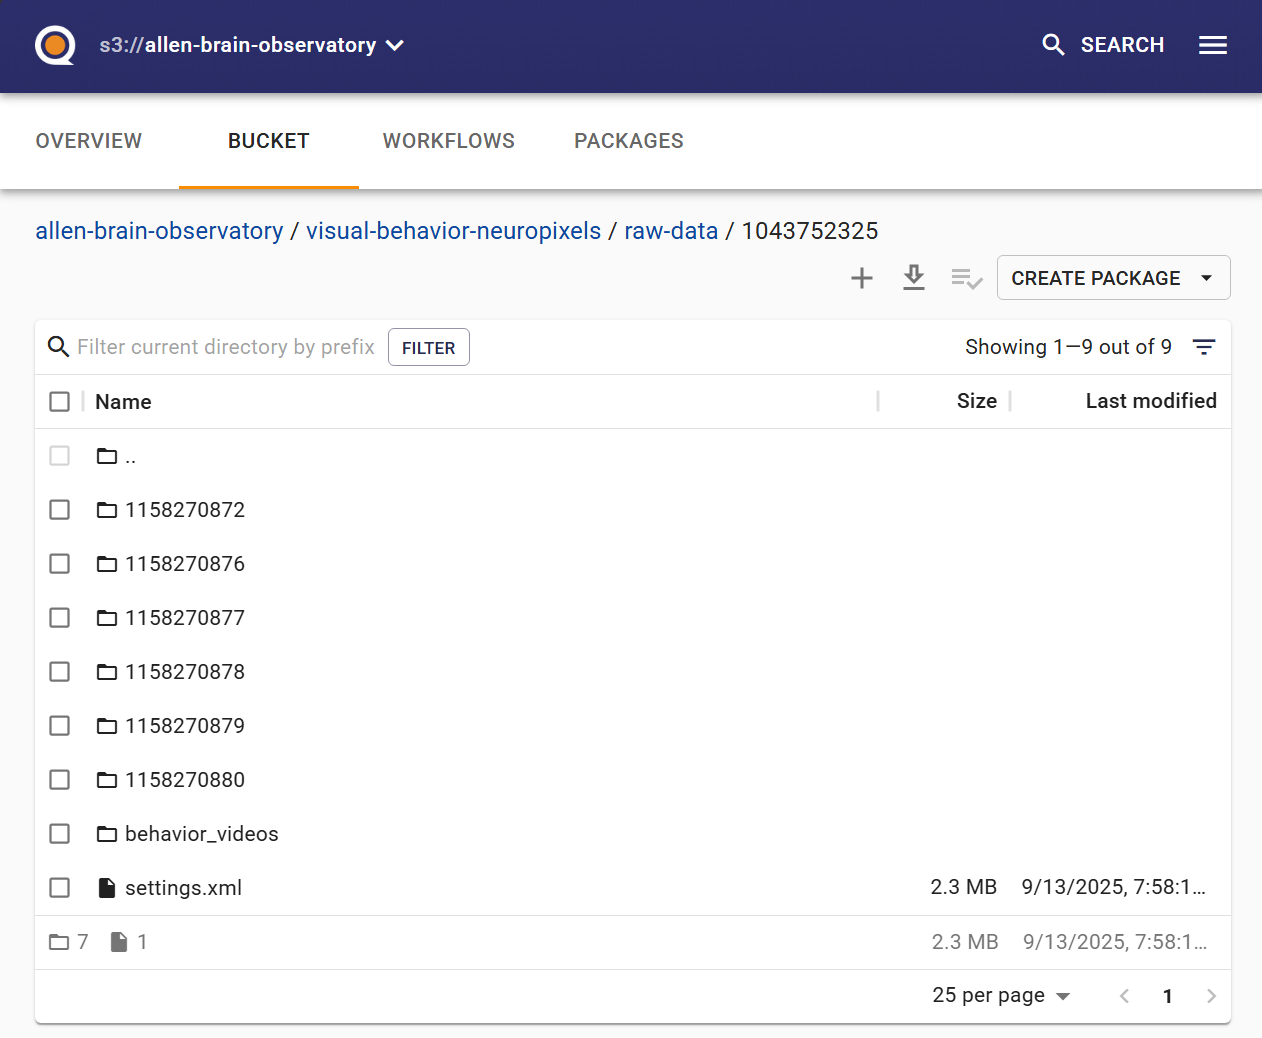


[https://open.quiltdata.com/b/allen-brain-observatory/tree/visual-behavior-neuropixels/raw-data/1043752325/1158270872/](https://open.quiltdata.com/b/allen-brain-observatory/tree/visual-behavior-neuropixels/raw-data/1043752325/1158270872/)

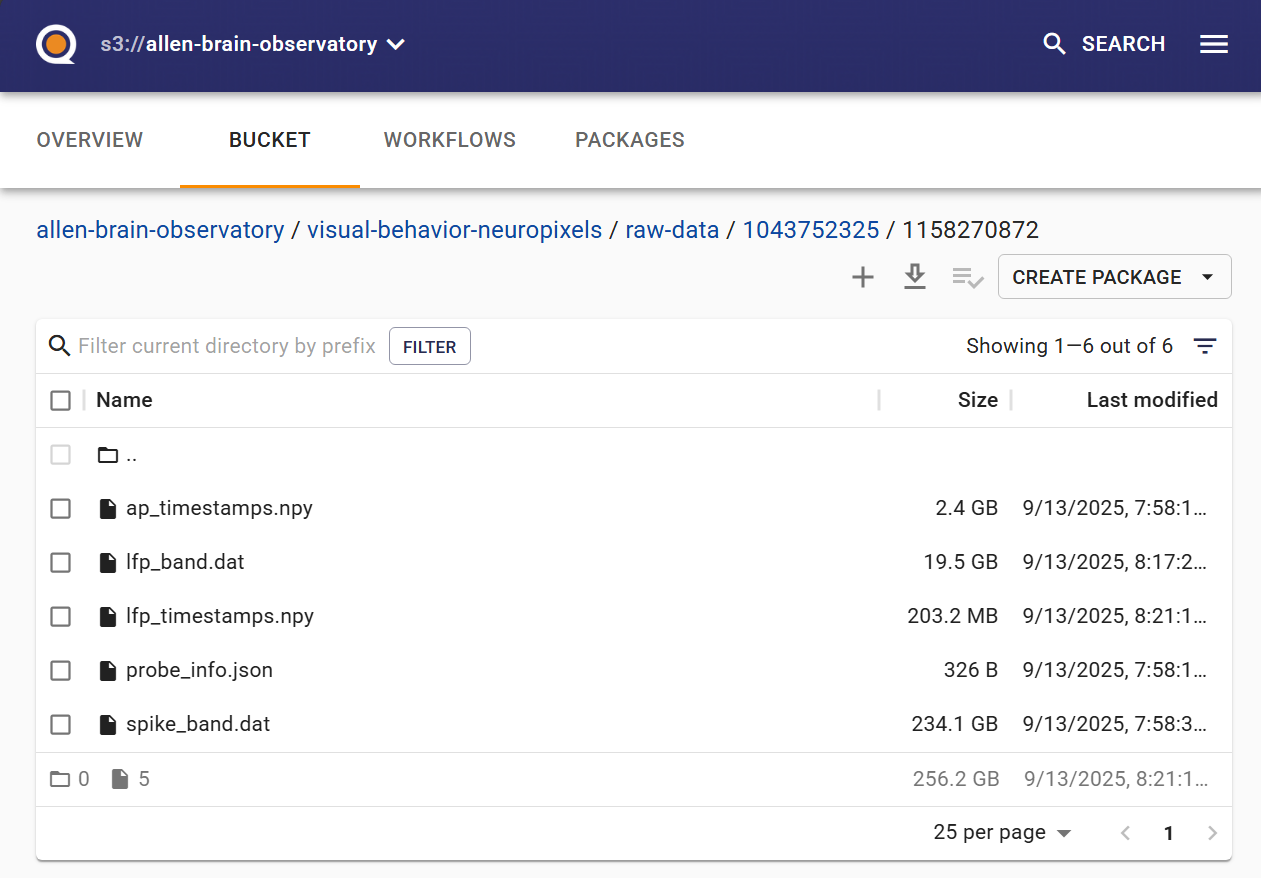

Each probe directory contains data in the Open Ephys binary format, but reorganized for simplicity.

See the Open Ephys documentation for full details: https://open-ephys.github.io/gui-docs/User-Manual/Data-formats/Binary-format.html#binaryformat

- continuous data is stored as 16-bit integers in 2 channels (AP and LFP) at different sampling rates
    - `spike_band.dat` is the AP band data: 300-10,000 Hz hardware bandpass filtered, sampled at 30 kS/s
    - `lfp_band.dat` is the LFP band data: 0.5-500Hz hardware bandpass filtered, sampled at 2.5 kS/s
- `ap_timestamps.npy`/`lfp_timestamps.npy` files contain `1 x num_samples` arrays of 64-bit floats stored in numpy format, corresponding
  to the time since the start of the session, the same as all other times in the NWB files.
- `probe_info.json` contains brief metadata about the probe: 
    ```json
    {
        "name": "probeA",
        "surface_channel": 348,
        "serial_number": 1158270872,
        "amplitude_scaling_factor": 0.5,
        "note": "'amplitude_scaling_factor' applies to data in spike_band and lfp_band .dat files; the scaling factor as already been applied to the 'gain' parameter in the settings.xml file"
    }
    ```
## Continuous data scaling
`amplitude_scaling_factor` in `probe_info.json` indicates a scaling factor of either `1.0` or `0.5` that **MUST** be applied
to the continuous data to adjust for differences in acquisition across sessions. 

The relevant metadata in the `settings.xml` file already captures this scaling, so if your spike sorter uses that information, no further action is needed.